In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
# importlib.reload(trades)
# importlib.reload(plots)
# importlib.reload(params)

import torch # not used

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


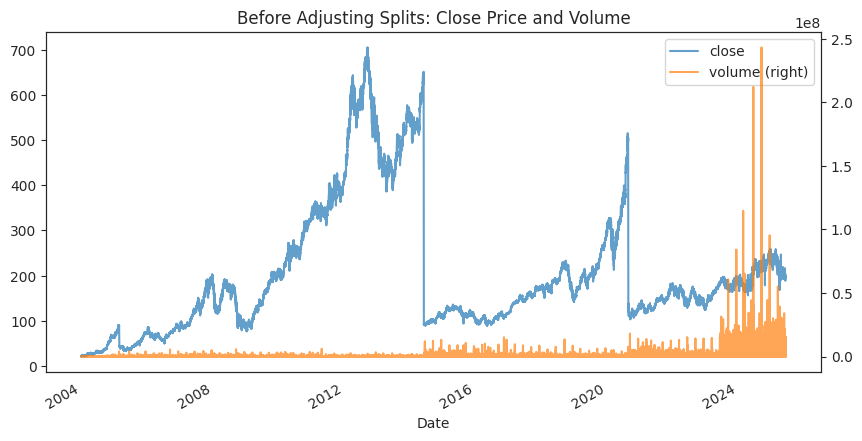

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


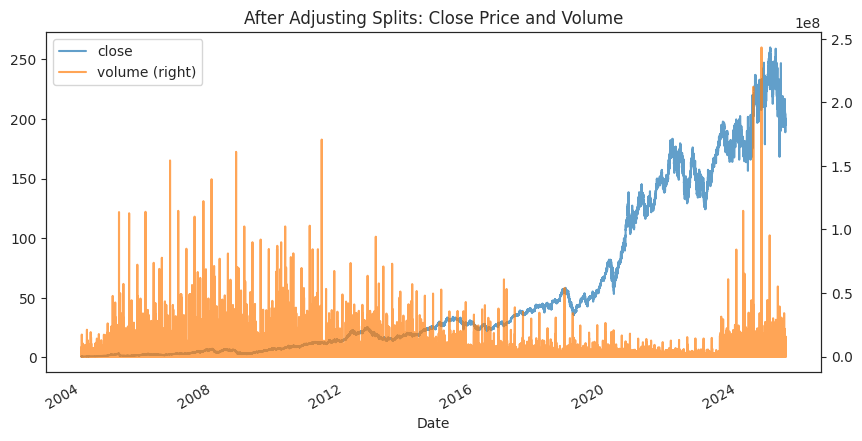

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 200
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile,
    smoothing_window
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',

        # — Trade-ID parameters —
        min_prof_thr             = min_prof_thr,            # profit % threshold (profit_pc ≥ min_prof_thr),  
                                                             # e.g. 0.5 → require at least 0.5% gain  
        max_down_prop            = max_down_prop,           # max retracement **fraction** of that profit range before exit,  
                                                             # e.g. 0.2 → allow up to 20% retracement of your gain  
        gain_tightening_factor   = gain_tightening_factor,  # dimensionless factor that tightens max_down_prop per %-gain,  
                                                             # applied as base/(1 + factor×gain%)  
        merging_retracement_thr  = merging_retracement_thr, # intermediate retracement **ratio** to merge two trades,  
                                                             # e.g. 0.3 → allow up to a 30% pullback of trade1’s range  
        merging_time_gap_thr     = merging_time_gap_thr,    # time-gap **ratio** to merge two trades,  
                                                             # gap_sec/(duration1+duration2), dimensionless  
    
        # — Continuous-signal parameters —
        pre_entry_decay          = pre_entry_decay,         # per-minute decay rate on pre-entry signal (0–1),  
                                                             # lower≈0.01→slow fade, higher≈0.1→fast fade  
        short_penal_decay        = short_penal_decay,       # exponent penalty on short-trade durations,  
                                                             # >1 amplifies suppression of very short signals  
    
        # — Final-trigger parameters —
        trailing_stop_pct        = trailing_stop_pct,       # trailing-stop distance **percent**,  
                                                             # internally divided by 100,  
                                                             # e.g. 0.5 → 0.5% stop loss  
        buy_threshold            = buy_threshold,           # normalized signal threshold ∈[0,1] to enter trade,  
                                                             # e.g. 0.5 → require 50% signal  
        top_percentile           = top_percentile,           # percentile **percent** to cap signal at 1.0,  
                                                             # e.g. 1.0 → top 1% of raw signals become 1.0  
        smoothing_window         = smoothing_window
    )


    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.03, 0.1), # increasing min to 0.03, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.5),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.5, 3.5),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 0.5),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.5, 3),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.01, 0.03), # decreasing max to 0.05, to avoid fast trading
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 0.5, 3.5),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.1), # increasing min to 0.03, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.1, 0.9),
        "top_percentile"          : trial.suggest_float("top_percentile", 0.5, 2.5),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [1,2,3,5,7,10,15,20,30])
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-08-29 20:20:25,908] A new study created in RDB with name: no-name-f83ef011-462e-46d2-a6cb-863525df260f


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.02day/s]
[I 2025-08-29 20:23:34,775] Trial 0 finished with value: 0.45608055555555554 and parameters: {'min_prof_thr': 0.04190263343991938, 'max_down_prop': 0.3254692616047628, 'gain_tightening_factor': 3.165934190339374, 'merging_retracement_thr': 0.16180862452622266, 'merging_time_gap_thr': 1.5985281794270567, 'pre_entry_decay': 0.015629113426371334, 'short_penal_decay': 2.326244111557537, 'trailing_stop_pct': 0.062337473464865095, 'buy_threshold': 0.11872532788885932, 'top_percentile': 0.9805406429949215, 'smoothing_window': 2}. Best is trial 0 with value: 0.45608055555555554.


→ Total return across 5400 trading days: $2462.84
→ Avg daily return (all days)          : $0.4561
→ Total trades                          : 41084
→ Avg return per trade                  : $0.0599



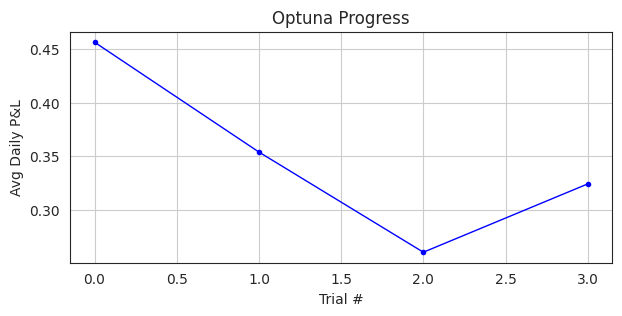

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.89day/s]
[I 2025-08-29 20:26:38,146] Trial 1 finished with value: 0.35397277777777775 and parameters: {'min_prof_thr': 0.034758236544843134, 'max_down_prop': 0.13276654658082296, 'gain_tightening_factor': 0.7009993928649989, 'merging_retracement_thr': 0.3963615688952228, 'merging_time_gap_thr': 0.6620303274820725, 'pre_entry_decay': 0.02599929253831843, 'short_penal_decay': 0.5917337442104228, 'trailing_stop_pct': 0.07180672717346276, 'buy_threshold': 0.7858590609610634, 'top_percentile': 1.62803789626283, 'smoothing_window': 1}. Best is trial 0 with value: 0.45608055555555554.


→ Total return across 5400 trading days: $1911.45
→ Avg daily return (all days)          : $0.3540
→ Total trades                          : 9002
→ Avg return per trade                  : $0.2123

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:51<00:00, 31.56day/s]
[I 2025-08-29 20:29:44,069] Trial 2 finished with value: 0.2608761111111111 and parameters: {'min_prof_thr': 0.08793927271886914, 'max_down_prop': 0.40881800008974556, 'gain_tightening_factor': 2.895361785222527, 'merging_retracement_thr': 0.13098410529035243, 'merging_time_gap_thr': 1.981928213363971, 'pre_entry_decay': 0.01933963867107144, 'short_penal_decay': 2.740742886902453, 'trailing_stop_pct': 0.07133715755876432, 'buy_threshold': 0.6371444286932471, 'top_percentile': 0.6051664148920441, 'smoothing_window': 1}. Best is trial 0 with value: 0.45608055555555554.


→ Total return across 5400 trading days: $1408.73
→ Avg daily return (all days)          : $0.2609
→ Total trades                          : 5499
→ Avg return per trade                  : $0.2562

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.19day/s]
[I 2025-08-29 20:32:48,996] Trial 3 finished with value: 0.3243792592592593 and parameters: {'min_prof_thr': 0.06549100011806919, 'max_down_prop': 0.2675710994609013, 'gain_tightening_factor': 1.7329069815135778, 'merging_retracement_thr': 0.2514498768148107, 'merging_time_gap_thr': 1.0587589020187909, 'pre_entry_decay': 0.021320151819943456, 'short_penal_decay': 1.3585878747121938, 'trailing_stop_pct': 0.053594474727029565, 'buy_threshold': 0.17076382711467578, 'top_percentile': 1.7919700875592706, 'smoothing_window': 20}. Best is trial 0 with value: 0.45608055555555554.


→ Total return across 5400 trading days: $1751.65
→ Avg daily return (all days)          : $0.3244
→ Total trades                          : 21096
→ Avg return per trade                  : $0.0830

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days:  11%|█         | 579/5400 [00:17<02:50, 28.20day/s]

In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
